In [1]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

# Heston Model Simulation

In the model of Heston (1993, "A Closed-Form Solution for Options with Stochastic Volatility with Applications to Bond and Currency Options", *Review of Financial Studies*), the risky asset volatility follows a stochastic process with a risk factor distinct from the price risk factor. We consider a variant of Heston's original model in which the Sharpe ratio (i.e., the expected excess return over the risk-free rate divided by volatility) is constant, while Heston's model assumes that the expected return is constant. In detail, our model reads

\begin{align*}
\frac{dS_t}{S_t}&=\left[r+\lambda\sqrt{V_t}\right]dt+\sqrt{V_t}dz_t^S \\
dV_t&=\kappa[\overline{V}-V_t]dt+\sigma_V\sqrt{V_t}dz_t^V
\end{align*}

*S* is the risky asset price, and $V$ is the instantaneous variance. $z^S$ is a Brownian motion representing the price risk, and $z^V$ is another Brownian motion representing volatility risk. The two Brownian motions are not independent because there is no reason in general for volatility risk to be independent from price risk. As a matter of fact, we saw in an exercise from the Time Series Analysis chapter that large volatilities tend to be associated with large returns.

The variance follows a mean-reverting process with a long-term mean $\overline{V}$ and a volatility $\sigma_V$. Note the square root factor, $\sqrt{V_t}$, in front of the Brownian increment in the second equation. It is this factor that ensures that the variance remains nonnegative.

## First Implementation

The simulation function below has a similar structure than the function `gbm_simulate` used in class, with more input parameters and more instructions in the body of the function because there are two processes to simulate instead of a single one. The function calculates an array of simulated prices and an array of simulated volatilities. To clearly identify these outputs, we let it return a dictionary of the two arrays with the keys 'price' and 'volatility'.

We also pass a parameter `transform` to the function, which specifies a transformation to apply to every simulated variance at instants 1, 2, ..., $T$. (No transformation is applied to the initial value.) The introduction of this technical parameter is motivated by the observation that the discretized variance process can take on negative values at some dates in some scenarios, and these negative values are unsuitable for the square root function. When we attempt to take the square root of a negative number, Numpy prints a warning message and uses a NaN, like in the following example:

In [2]:
np.sqrt(-1)

C:\Users\v_milhau\AppData\Local\Temp\ipykernel_14460\3438155168.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(-1)


np.float64(nan)

The role of Numpy is to perform numerical calculations, so it is unaware of imaginary numbers, although Python has a constant `1j` to represent the imaginary unit $\sqrt{-1}$:

In [3]:
1j**2

(-1+0j)

Our input function `transform` must accept a Numpy array and return a Numpy array with the same shape. In practice, we will take it equal to the identity function, which returns whatever input is passed to it without doing any calculation, or a function that removes negative values.

In [4]:
def identity(x):
    return x

def heston_simulate(rate: float, sharpe_ratio: float, initial_price: float,
                    kappa: float, lt_var: float, vol_var: float, initial_var: float, rho: float,
                    n_paths: int, time_step: float, n_periods: int,
                    rng: np.random._generator.Generator,
                    transform=identity):
    """
    Simulate paths for price and volatility under the Heston model.
    Note that this function has a side effect because it changes the state of the random number generator.
    """
    
    logS = np.empty((n_periods + 1, n_paths))  # Pre-allocation
    V = np.empty((n_periods + 1, n_paths))
    
    logS[0, :] = np.log(initial_price)  # Initial log price
    V[0, :] = initial_var
    
    loading2 = np.sqrt(1 - rho**2)
    
    for i in range(1, n_periods + 1):
        std_innov1 = rng.standard_normal(n_paths)
        
        sigma = np.sqrt(V[i - 1, :])  # Current volatility
        
        logS[i, :] = logS[i - 1, :] + (rate + sharpe_ratio * sigma - .5 * V[i - 1, :]) * time_step \
            + sigma * np.sqrt(time_step) * std_innov1
            
        std_innov2 = rng.standard_normal(n_paths)
            
        V[i, :] = V[i - 1, :] + kappa * (lt_var - V[i - 1, :]) * time_step \
            + vol_var * sigma * np.sqrt(time_step) * (rho * std_innov1 + loading2 * std_innov2)
            
        V[i, :] = transform(V[i, :])  # Transform simulated variances
        
    S = np.exp(logS)    
    
    return {'price': S, 'volatility': np.sqrt(V)}

## First Set of Simulations

Let us test the function with parameter values borrowed from column 2 of Table 6 in Aït-Sahalia and Kimmel (2007, Estimation of Stochastic Volatility Models, *Journal of Financial Economics*). These values were obtained by calibrating the Heston model to the S&P 500 index and the CBOE Volatility Index (also known as VIX). The data used in Aït-Sahalia and Kimmel's paper are daily and span the period from January 2, 1990 to September 30, 2003.

We complete Aït-Sahalia and Kimmel's set of parameter values by setting other parameters as follows. The short-term interest rate is 2%, the stock Sharpe ratio is 0.40, the initial stock price is \\$1 (note that this value is only a scaling factor for simulated prices) and the initial variance is $\overline{V}$. Because the variance process starts at its long-term mean, we do not expect the simulations to display an increasing or a decreasing trend.

In [1]:
rate = .02
initial_price = 1
sharpe_ratio = .40
kappa = 5.07
vol_var = .48
lt_var = .0457
initial_var = lt_var
rho = -.7670
n_paths = 10**4
time_step = 1 / 52
n_periods = 52

rng = np.random.default_rng(seed=123)

SV = heston_simulate(rate, sharpe_ratio, initial_price,
                     kappa, lt_var, vol_var, initial_var, rho,
                     n_paths, time_step, n_periods,
                     rng)

NameError: name 'np' is not defined

We get messages warning us of the ""invalid" (understand, negative) values encountered in some calculations.

These issues can be avoided by flooring the simulated values to 0, i.e., by specifying a transform function that cuts its argument to 0.

In [6]:
rng = np.random.default_rng(seed=123)

def max_0(x: np.ndarray):
    return np.maximum(0., x)

SV = heston_simulate(rate, sharpe_ratio, initial_price,
                     kappa, lt_var, vol_var, initial_var, rho,
                     n_paths, time_step, n_periods,
                     rng,
                     transform=max_0)

We have got rid of the warning messages since the transformation ensures that we never attempt to take the square root of a negative number, but at the cost of having a fair number of minuscule volatility values. Counting the paths in which the minimum is less than $10^{-15}$, we see that there are almost 20% of them:

In [7]:
(SV['volatility'].min(axis=0) < 1e-15).sum()

np.int64(1956)

This is not a numerical problem at this stage, and this is not even inconsistent with the model, which does not preclude such infinitesimal values, but we must be careful if we subsquently divide by the volatility, for the zero volatilities will cause issues then.

## Second Set of Simulations

Let us now try the parameter values borrowed from Table 1 (column "True value") of the aforementioned paper by Aït-Sahalia and Kimmel (2007), hoping that they will avoid the numerical issues.

In [8]:
rate = .02
initial_price = 1
sharpe_ratio = .40
kappa = 3
vol_var = .25
lt_var = .1
initial_var = lt_var
rho = -.8
n_paths = 10**4
time_step = 1 / 52
n_periods = 52

rng = np.random.default_rng(seed=123)

SV = heston_simulate(rate, sharpe_ratio, initial_price,
                     kappa, lt_var, vol_var, initial_var, rho,
                     n_paths, time_step, n_periods,
                     rng)

Now, we no longer have any warning message, indicating that no attempt at taking the square root of a negative number occurred. Let us look at the distribution of volatilities across weeks and scenarios:

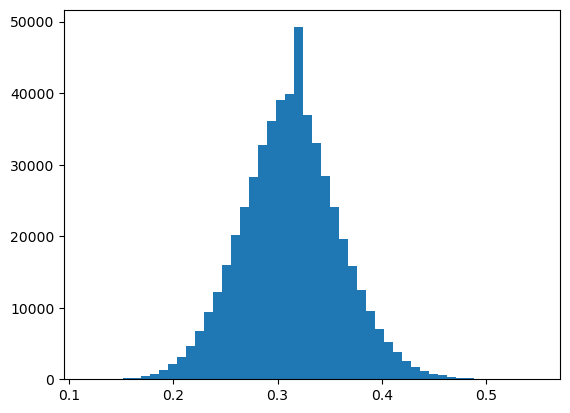

In [9]:
plt.hist(SV['volatility'].flatten(), bins=50);

The distribution no longer involves negative values, even though it is narrower than the distribution of rolling-window volatilites of the S&P 500, which features many more big values. (See the notebook for the session on Financial Analytics.)

Let us plot the first 5 simulated paths for the stock price and its volatility.

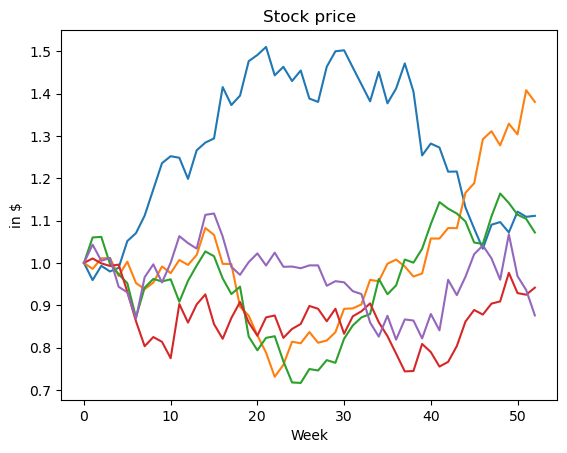

In [10]:
plt.plot(SV['price'][:, 0 : 5]);
plt.xlabel('Week')
plt.ylabel('in $')
plt.title('Stock price');

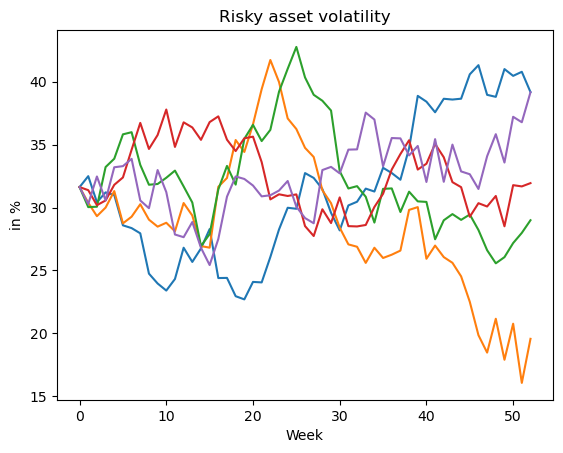

In [11]:
plt.plot(100 * SV['volatility'][:, 0 : 5]);
plt.xlabel('Week')
plt.ylabel('in %')
plt.title('Risky asset volatility');

## Alternative Implementation, with Classes

Because we have two processes to simulate, we must specify more parameter values than for the Geometric Brownian motion, so our function `heston_simulate` has 12 input parameters. Functions with too many parameters are difficult to use because it is easy to forget one or to switch them unintentionally. Classes are useful to gather parameters in a single object, so we propose a second version of the code that uses a class `Heston` containing the parameters of the Heston model. This class is implemented as a dataclass, so that Python takes care of writing the class constructor. Initial conditions $S_0$ and $V_0$ are still treated as inputs to the simulation method.

We apply the same logic to the simulation parameters, namely the number of paths, the time step, the number of periods per path and the random number generator. As opposed to passing them individually to the simulation function, we gather them in a dedicated class `Simulation`. This class has no methods; it is simply intended as a data collection.

In [12]:
@dataclass
class Simulation:
    n_paths: int
    time_step: float
    n_periods: int
    rng: np.random._generator.Generator

@dataclass
class Heston:
    rate: float
    sharpe_ratio: float
    kappa: float
    vol_var: float
    lt_var: float
    rho: float
    
    def simulate(self, initial_price: float, initial_var: float,
                 Sim: Simulation, transform=identity):
        """
        Simulate paths for price and volatility under the Heston model.
        Note that this function has a side effect because it changes the state of the random number generator.
        """
    
        logS = np.empty((Sim.n_periods + 1, Sim.n_paths))  # Pre-allocation
        V = np.empty((Sim.n_periods + 1, Sim.n_paths))
    
        logS[0, :] = np.log(initial_price)  # Initial log price
        V[0, :] = initial_var
    
        loading2 = np.sqrt(1 - self.rho**2)
    
        for i in range(1, Sim.n_periods + 1):
            std_innov1 = rng.standard_normal(Sim.n_paths)
        
            sigma = np.sqrt(V[i - 1, :])  # Current volatility
        
            logS[i, :] = logS[i - 1, :] + (self.rate + self.sharpe_ratio * sigma - .5 * V[i - 1, :]) * time_step \
                + sigma * np.sqrt(time_step) * std_innov1
            
            std_innov2 = rng.standard_normal(Sim.n_paths)
            
            V[i, :] = V[i - 1, :] + self.kappa * (self.lt_var - V[i - 1, :]) * time_step \
                + self.vol_var * sigma * np.sqrt(time_step) * (self.rho * std_innov1 + loading2 * std_innov2)
            
            V[i, :] = transform(V[i, :])  # Remove negative variances
        
        S = np.exp(logS)    
    
        return {'price': S, 'volatility': np.sqrt(V)}


H = Heston(rate=.02, sharpe_ratio=.40, kappa=3.,
           vol_var=.25, lt_var=.1, rho=-.8)

Sim = Simulation(n_paths=10**4, time_step=1/52, n_periods=52, rng=rng)

rng = np.random.default_rng(seed=123)

SV2 = H.simulate(initial_price=1, initial_var=H.lt_var, Sim=Sim)

The simulation function is now the method `simulate`, which takes only 4 arguments (counting the instance of the class `Heston`) instead of 12. The above implementation allows for a clearer separation between the parameters of the Heston model (the interest rate, the Sharpe ratio and the parameters of the volatility process) and the parameters of the simulation (the number of paths, the number of periods, the time step and the random number generator).

Of course, this code returns the exact same results as the code that does not use classes, as can be checked by visually comparing the first 5 paths for the stock price with those returned by the first piece of code.

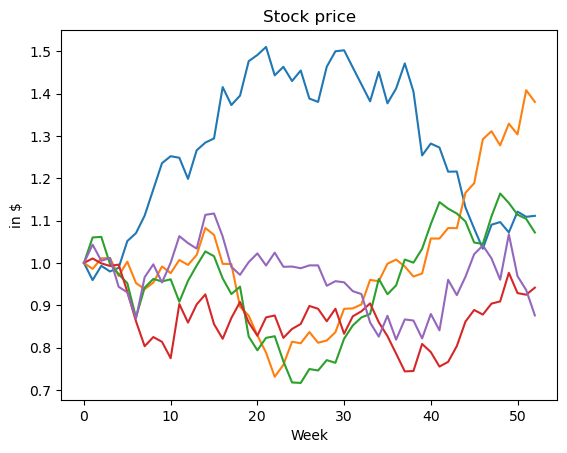

In [13]:
plt.plot(SV2['price'][:, 0 : 5]);
plt.xlabel('Week')
plt.ylabel('in $')
plt.title('Stock price');

## Checking Simulations

Let us calculate the weekly logarithmic returns on the simulated stock data and the weekly changes in the simulated variance.

In [14]:
lret_S = np.diff(np.log(SV2['price']), axis=0)

dV = np.diff(SV['volatility']**2, axis=0)

We have 10,000 time series of logarithmic returns, so we calculate the variance of weekly returns for each series, thus obtaining 10,000 variance values, for which we calculate the average. 

In [15]:
lret_S.var(axis=0).mean() * 52, H.lt_var

(np.float64(0.0980769330982997), 0.1)

The average time series variance across paths is close to the theoretical values of 0.1.

To check that the simulation correctly captures the dependencies between processes, we calculate the average correlation between stock returns and changes in variance across paths:

In [16]:
np.array(list(map(lambda i: np.corrcoef(lret_S[:, i], dV[:, i])[0, 1], range(0, Sim.n_paths)))).mean(), H.rho

(np.float64(-0.7924620255950856), -0.8)

Here again, the sample moment implied by simulated scenarios is close to the theoretical value.

Finally, let us look at the distribution of the 1-year stock returns:

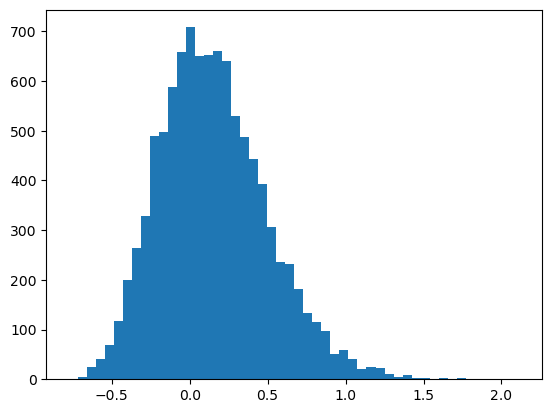

In [17]:
ret = (lambda x: x[-1] / x[0] - 1.)(SV2['price'])

plt.hist(ret, bins=50);

There are quite a few abnormal values, such as -50% in the left tail and +100% in the right tail, but the expected return inferred from the simulation is:

In [18]:
ret.mean()

np.float64(0.15307387641458375)

An expected return of 15.3% in a year looks rather optimistic, but this value is in line with the parameters that we passed. To that the order of magnitude is correct, let us calculate the expected annual return if the stock were to follow a Geometric Brownian Motion with a constant volatility equal to the square root of the long-term variance:

In [19]:
np.exp(rate + np.sqrt(lt_var) * sharpe_ratio) - 1

np.float64(0.15776463408491703)

This value is close to the simulated expected return.